## Motivation
Currently AI is advancing in the field of healthcare to improve detection of malignant tumors, give treatment recommendations, engage patients and support in administrative activities (Davenport and Kalakota 2019). Our goal is to contribute to this field by applying a neural network with transfer learning on a dataset with the aim to detect malignant cells of breast cancer. 

According to Krebsliga Schweiz (2021), there are 6’250 new cases and 1’410 deaths associated with breast cancer in Switzerland every year. Early diagnosis and treatment are a key to increasing the 5-year survival rate of patients.  

From a technical standpoint we want to investigate the performance differences between neural networks with and without transfer learning in the field of tumor detection.

## Data

We use the Kaggle dataset: Breast Histopathology Images, which contains 277’524 images that are classified whether the sample is positive or negative for Invasive Ductal Carcinoma (IDC). Therefore, we face a binary classification problem with this dataset. The sample dataset contains images scanned at 40x zoom that are prepared in 50 x 50-pixel patches.

[Kaggle Dataset](https://www.kaggle.com/paultimothymooney/breast-histopathology-images)

### Import Packages

In [1]:
import pandas
import numpy
import datetime
import pickle

# Graphs, visualizations
import matplotlib.pyplot as plt
import seaborn as sn

# import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam, SGD

import sklearn
from sklearn.model_selection import train_test_split

In [2]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### Load the Data

In [3]:
# Import Data From Pickle file

with open('y.pickle', 'rb') as f:
    y_data = pickle.load(f)
f.close()
y_data

with open('X.pickle', 'rb') as f:
    X_data = pickle.load(f)
f.close()

In [4]:
# lower the number of epochs
epochs = 150

total = numpy.asarray(y_data).shape[0]
pos = sum(numpy.asarray(y_data))
neg = total - pos

# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
# weight_for_0 = (1 / neg) * (total / 2.0)
# weight_for_1 = (1 / pos) * (total / 2.0)

weight_for_0 = (1 / neg) * total
weight_for_1 = (1 / pos) * total

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 1.40
Weight for class 1: 3.52


### Learnings
* The data of positive and negative samples is unbalanced, where patients have more negative patches than positive ones
* This could lead to an imbalanced result where we classify more patches as negative, which would be a severe mistake in cancer detection. A confusion matrix should be sufficient so verify this concern, when the model is trained

In [5]:
#Train-validation-test split
# train test split for validation after training x_test is never touched or looked at during training
x_train,x_test,y_train,y_test=sklearn.model_selection.train_test_split(numpy.asarray(X_data),
                                                                       numpy.asarray(y_data),
                                                                       test_size=.3,
                                                                       random_state=42)

# train test split for validation during training
x_train,x_val,y_train,y_val=sklearn.model_selection.train_test_split(x_train,
                                                                     y_train,
                                                                     test_size=.2,
                                                                     random_state=42)
# free the memory
del X_data
del y_data

#Dimension of the kaggle dataset
print((x_train.shape,y_train.shape))
print((x_val.shape,y_val.shape))
print((x_test.shape,y_test.shape))

((155412, 50, 50, 3), (155412,))
((38854, 50, 50, 3), (38854,))
((83258, 50, 50, 3), (83258,))


### Functions for plotting

In [6]:
def acc_plot(history):
    plt.plot(history.history['accuracy'], alpha=1, color='#464749')
    plt.plot(history.history['val_accuracy'], alpha=1, color='#c07156')
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.xlabel('epoch')
    plt.legend(['train_acc', 'val_acc'], loc='upper left')
    return plt

def loss_plot(history):
    plt.plot(history.history['loss'][1:], alpha=1, color='#464749')
    plt.plot(history.history['val_loss'], alpha=1, color='#c07156')
    plt.xlabel('epoch')
    plt.legend(['train_loss', 'val_loss'], loc='upper left')
    return plt

def plot_prc(name, labels, predictions, **kwargs):
    precision, recall, _ = sklearn.metrics.precision_recall_curve(labels, predictions)

    plt.plot(precision, recall, label=name, linewidth=2, **kwargs)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')
    
def conf_matrix(model, x_test, y_test):
    
    y_pred = [1 * (x[0]>=0.5) for x in model.predict(x_test)]

    matrix = sklearn.metrics.confusion_matrix(y_test, y_pred)
    df_cm = pandas.DataFrame(matrix, index = [i for i in ['No Cancer (actual)', 'Cancer (actual)']],
                      columns = [i for i in ['predict No Cancer', 'predict Cancer']])
    plt.figure(figsize = (10,7))
    sn.heatmap(df_cm, annot=True, fmt='d')
    return plt

### General model settings

Given the expermients conducted with dense layers, the geral settings for all transfer learning networks are as following:\
batch_size = 1024\
learning_rate = 0.001\
Adam Optimizer, earlie stopping and learning rate annealer, both with a patience of 20\
As the transfer architecture requires way more computation power, we will only train the network for maximally 50 epochs.

In [7]:
learningRate=0.001
batchSize = 256
epochs = 50

#Early stopping callback
es = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=20, verbose=2,
                                      mode='max', baseline=None, restore_best_weights=True)
#Learning Rate Annealer
lrr = keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',
                       factor=.1,
                       patience=20,
                       min_lr=1e-4,
                       verbose=2)
# Input shape
input_shape = (50, 50, 3)

# Transfer learning

For our transfer learning setting, we use Resnet50. Resnet50 is a deep convolutional network with, as the name states, 50 layers. Out of these 50 layers, 48 are convolutional layers, besides that it contains an average pooling layer and a maxpooling layer.\
It was trained with more than a million images from ImageNet (http://www.image-net.org/). Originally, the network was trained for multiclass classification with 1000 categories.\
The Keras API allows to load the Resnet50 with weights trained on image net. This is done with the keyword weights='imagenet'. Furthermore, Keras enables the user to define his own input shape. This is only possible if the original dense layer at the top of the network is not loaded. Therefore we use include_top=False. However, the number of channels must be 3 as the network was trained on colored images. Of course, we also freez the pretained weights, meaning that we don't update them during training.\
Firstly, we implement a simple network using resnet50. We call it simple, as we use just two denslayers to connect the Resnet50 with the desired output for our task. Before the Resnet50, we don't use any layer at all, but connect our input, images of the shape 50x50x3, directly to the Resnet50.\
In a next step, we try to enhance the model by adding layers before the Resnet50 and in a third step by adding a more complex architecture after Resnet50.

In this part of the project, we'd like to focus on the effect of the layers before and after the pretrained model, thus we don't conduct any experiments with different hyperparameters.

## Simple Transfer learning

In [7]:
model_input = keras.Input(shape=input_shape)

resnet = keras.applications.ResNet50(include_top=False,weights='imagenet',input_shape=(50,50,3))
resnet.trainable=False
x = resnet(model_input,training=False)

x = keras.layers.Flatten()(x)
x = keras.layers.Dense(512, activation='relu')(x) # dense layer 1 
output = keras.layers.Dense(units=1, activation='sigmoid')(x)

In [8]:
model = keras.Model(inputs = model_input, outputs = output)
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 50, 50, 3)]       0         
_________________________________________________________________
resnet50 (Functional)        (None, 2, 2, 2048)        23587712  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               4194816   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 513       
Total params: 27,783,041
Trainable params: 4,195,329
Non-trainable params: 23,587,712
_________________________________________________________________


In [9]:
model.compile(loss="binary_crossentropy", optimizer=Adam(epsilon=0.1, learning_rate=learningRate), metrics=["accuracy"])

history=model.fit(x_train, y_train,
                  batch_size=batchSize, epochs=epochs,
                  validation_data=(x_val,y_val),
                  callbacks=[es, lrr],
                 ) 
history1 = history

Epoch 1/50
608/608 [==============================] - 28s 46ms/step - loss: 0.4012 - accuracy: 0.8319 - val_loss: 0.3565 - val_accuracy: 0.8492
Epoch 2/50
608/608 [==============================] - 26s 43ms/step - loss: 0.3509 - accuracy: 0.8511 - val_loss: 0.3405 - val_accuracy: 0.8545
Epoch 3/50
608/608 [==============================] - 26s 43ms/step - loss: 0.3376 - accuracy: 0.8566 - val_loss: 0.3431 - val_accuracy: 0.8553
Epoch 4/50
608/608 [==============================] - 26s 43ms/step - loss: 0.3296 - accuracy: 0.8603 - val_loss: 0.3368 - val_accuracy: 0.8592
Epoch 5/50
608/608 [==============================] - 26s 43ms/step - loss: 0.3223 - accuracy: 0.8639 - val_loss: 0.3468 - val_accuracy: 0.8543
Epoch 6/50
608/608 [==============================] - 26s 43ms/step - loss: 0.3152 - accuracy: 0.8665 - val_loss: 0.3315 - val_accuracy: 0.8606
Epoch 7/50
608/608 [==============================] - 26s 43ms/step - loss: 0.3122 - accuracy: 0.8686 - val_loss: 0.3351 - val_accuracy:

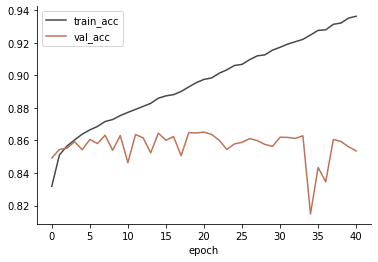

In [41]:
# plot accuracy
plt = acc_plot(history1)
plt.show()

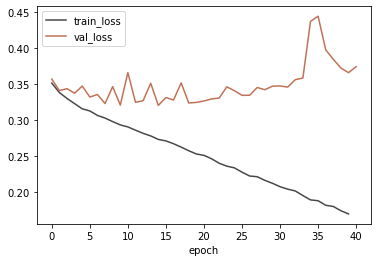

In [43]:
# plot loss
plt = loss_plot(history1)
plt.show()

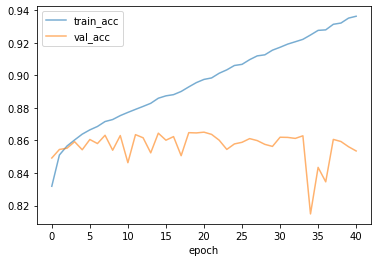

In [10]:
# plot accuracy
plt = acc_plot(history)
plt.show()

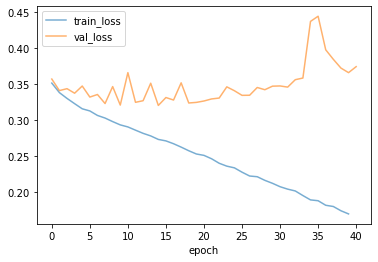

In [11]:
# plot loss
plt = loss_plot(history)
plt.show()

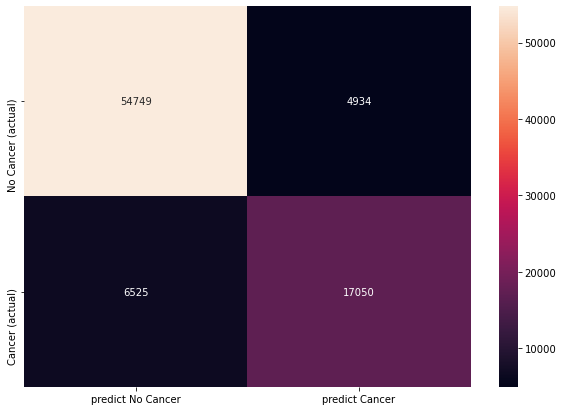

In [12]:
plt = conf_matrix(model, x_test, y_test)
plt.show()

### Advanced Transfer Learning I

As mentioned, we try to improve the performance by changing the architecture before the Resnet50. For the simple model, we connected our input directly to the Resnet50. Now, we use UpSamling2D layers, these layers just double the input size but are not able to learn anything. Thus, for the advanced model, each UpSamling2D layer is followed by a Conv2D layer that maintains the shape. The intuition is that the Conv2D layer can learn something from the upsampled input before upsampling it further.

In [13]:
model_input = keras.Input(shape=input_shape)
beforeModel = keras.layers.UpSampling2D()(model_input)
beforeModel = keras.layers.Conv2D(3, 3, strides=1, padding="same")(beforeModel)
beforeModel = keras.layers.UpSampling2D()(beforeModel)
beforeModel = keras.layers.Conv2D(3, 3, strides=1, padding="same")(beforeModel)

resnet = keras.applications.ResNet50(include_top=False,weights='imagenet',input_shape=(200,200,3))
resnet.trainable=False
x = resnet(beforeModel,training=False)

x = keras.layers.Flatten()(x)
x = keras.layers.Dense(512, activation='relu', use_bias=False)(x) # dense layer 1 
output = keras.layers.Dense(units=1, activation='sigmoid', use_bias=False)(x)

In [14]:
model = keras.Model(inputs = model_input, outputs = output)
model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 50, 50, 3)]       0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 100, 100, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 100, 100, 3)       84        
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 200, 200, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 200, 200, 3)       84        
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten_1 (Flatten)          (None, 100352)           

In [15]:
batchSize = 64

model.compile(loss="binary_crossentropy", optimizer=Adam(epsilon=0.1, learning_rate=learningRate), metrics=["accuracy"])

history=model.fit(x_train, y_train,
                  batch_size=batchSize, epochs=epochs,
                  validation_data=(x_val,y_val),
                  callbacks=[es, lrr],
                 )  
history2=history

Epoch 1/50
2429/2429 [==============================] - 764s 315ms/step - loss: 0.3612 - accuracy: 0.8437 - val_loss: 0.3253 - val_accuracy: 0.8578
Epoch 2/50
2429/2429 [==============================] - 765s 315ms/step - loss: 0.3101 - accuracy: 0.8667 - val_loss: 0.3022 - val_accuracy: 0.8706
Epoch 3/50
2429/2429 [==============================] - 765s 315ms/step - loss: 0.2840 - accuracy: 0.8791 - val_loss: 0.3340 - val_accuracy: 0.8598
Epoch 4/50
2429/2429 [==============================] - 765s 315ms/step - loss: 0.2606 - accuracy: 0.8905 - val_loss: 0.2915 - val_accuracy: 0.8749
Epoch 5/50
2429/2429 [==============================] - 766s 315ms/step - loss: 0.2359 - accuracy: 0.9013 - val_loss: 0.2995 - val_accuracy: 0.8767
Epoch 6/50
2429/2429 [==============================] - 765s 315ms/step - loss: 0.2092 - accuracy: 0.9138 - val_loss: 0.3124 - val_accuracy: 0.8749
Epoch 7/50
2429/2429 [==============================] - 766s 315ms/step - loss: 0.1787 - accuracy: 0.9274 - val_

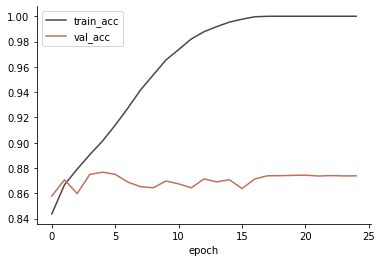

In [44]:
# plot accuracy
plt = acc_plot(history2)
plt.show()

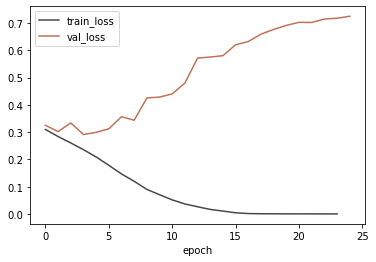

In [45]:
# plot loss
plt = loss_plot(history2)
plt.show()

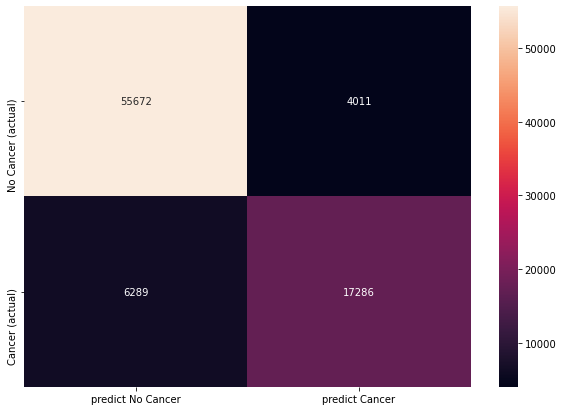

In [18]:
plt = conf_matrix(model, x_test, y_test)
plt.show()

### Advanced Transfer Learning II

Finally, we attempt to improve the performance further by altering the architecture after the Resnet50. We introduce two types of regularization layers, namely BatchNormalization and Dropout. Besides that, we added an additional dense layer, so in total we use two dense layers and one output layer with sigmoid activation. After each dense layer, expect the output layer, we apply first a dropout layer with a dropout probability of 20% and then a batch normalization. After flattening the output of the resnet, we also apply a batch normalization. 

In [19]:
model_input = keras.Input(shape=input_shape)
beforeModel = keras.layers.UpSampling2D()(model_input)
beforeModel = keras.layers.Conv2D(3, 3, strides=1, padding="same")(beforeModel)
beforeModel = keras.layers.UpSampling2D()(beforeModel)
beforeModel = keras.layers.Conv2D(3, 3, strides=1, padding="same")(beforeModel)
resnet = keras.applications.ResNet50(include_top=False,weights='imagenet',input_shape=(200,200,3))
resnet.trainable=False
x = resnet(beforeModel,training=False)

x = keras.layers.Flatten()(x)
x = keras.layers.Dense(1024, activation='relu')(x) # dense layer 1 

x = keras.layers.Dropout(0.2)(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(512, activation='relu')(x) # dense layer 2
x = keras.layers.Dropout(0.2)(x)
output = keras.layers.Dense(units=1, activation='sigmoid')(x)

In [20]:
model = keras.Model(inputs = model_input, outputs = output)
model.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 50, 50, 3)]       0         
_________________________________________________________________
up_sampling2d_2 (UpSampling2 (None, 100, 100, 3)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 100, 100, 3)       84        
_________________________________________________________________
up_sampling2d_3 (UpSampling2 (None, 200, 200, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 200, 200, 3)       84        
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten_2 (Flatten)          (None, 100352)           

In [21]:
model.compile(loss="binary_crossentropy", optimizer=Adam(epsilon=0.1, learning_rate=learningRate), metrics=["accuracy"])

history=model.fit(x_train, y_train,
                  batch_size=batchSize, epochs=epochs,
                  validation_data=(x_val,y_val),
                  callbacks=[es, lrr],
                 )
history3 = history

Epoch 1/50
2429/2429 [==============================] - 787s 324ms/step - loss: 0.3869 - accuracy: 0.8338 - val_loss: 0.3444 - val_accuracy: 0.8536
Epoch 2/50
2429/2429 [==============================] - 787s 324ms/step - loss: 0.3482 - accuracy: 0.8515 - val_loss: 0.3341 - val_accuracy: 0.8590
Epoch 3/50
2429/2429 [==============================] - 787s 324ms/step - loss: 0.3311 - accuracy: 0.8594 - val_loss: 0.3290 - val_accuracy: 0.8634
Epoch 4/50
2429/2429 [==============================] - 786s 324ms/step - loss: 0.3196 - accuracy: 0.8651 - val_loss: 0.3465 - val_accuracy: 0.8504
Epoch 5/50
2429/2429 [==============================] - 787s 324ms/step - loss: 0.3115 - accuracy: 0.8687 - val_loss: 0.3171 - val_accuracy: 0.8664
Epoch 6/50
2429/2429 [==============================] - 787s 324ms/step - loss: 0.3048 - accuracy: 0.8709 - val_loss: 0.3075 - val_accuracy: 0.8709
Epoch 7/50
2429/2429 [==============================] - 786s 324ms/step - loss: 0.3022 - accuracy: 0.8727 - val_

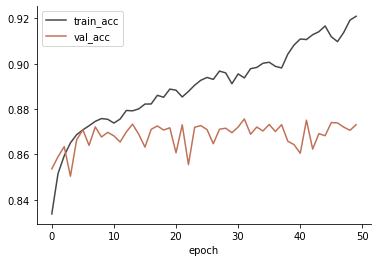

In [46]:
# plot accuracy
plt = acc_plot(history3)
plt.show()

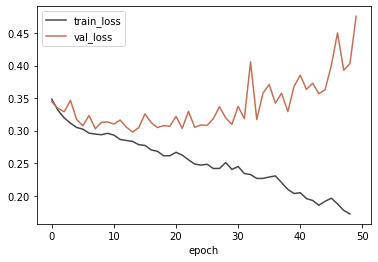

In [47]:
# plot loss
plt = loss_plot(history3)
plt.show()

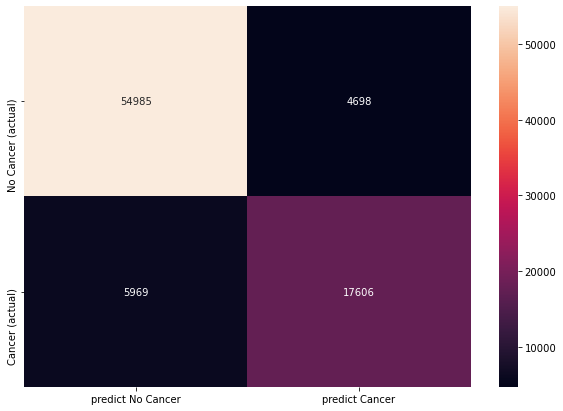

In [24]:
plt = conf_matrix(model, x_test, y_test)
plt.show()

# Balanced weights

In [8]:
# Reduce patience for early stopping

#Early stopping callback
es = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=6, verbose=2,
                                      mode='max', baseline=None, restore_best_weights=True)

In [9]:
model_input = keras.Input(shape=input_shape)
beforeModel = keras.layers.UpSampling2D()(model_input)
beforeModel = keras.layers.Conv2D(5, 5, strides=1, padding="same")(beforeModel)
beforeModel = keras.layers.UpSampling2D()(beforeModel)
beforeModel = keras.layers.Conv2D(3, 3, strides=1, padding="same")(beforeModel)
beforeModel = keras.layers.experimental.preprocessing.Resizing(
    224, 224, interpolation="bilinear")(beforeModel)
resnet = keras.applications.ResNet50(include_top=False,weights='imagenet',input_shape=(224,224,3))
resnet.trainable=False
x = resnet(beforeModel,training=False)

x = keras.layers.Flatten()(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(512, activation='relu')(x) # dense layer
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dropout(0.4)(x)
output = keras.layers.Dense(units=1, activation='sigmoid')(x)

In [10]:
model = keras.Model(inputs = model_input, outputs = output)
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 50, 50, 3)]       0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 100, 100, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 100, 100, 5)       380       
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 200, 200, 5)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 200, 200, 3)       138       
_________________________________________________________________
resizing (Resizing)          (None, 224, 224, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)       

In [13]:
batchSize = 32

model.compile(loss="binary_crossentropy", optimizer=Adam(epsilon=0.1, learning_rate=learningRate), metrics=["accuracy"])

history=model.fit(x_train, y_train,
                  batch_size=batchSize, epochs=epochs,
                  validation_data=(x_val,y_val),
                  callbacks=[es, lrr], class_weight=class_weight
                 )
history4 = history

Epoch 1/50
4857/4857 [==============================] - 887s 183ms/step - loss: 0.8488 - accuracy: 0.8130 - val_loss: 0.8046 - val_accuracy: 0.6561
Epoch 2/50
4857/4857 [==============================] - 888s 183ms/step - loss: 0.7336 - accuracy: 0.8413 - val_loss: 0.3211 - val_accuracy: 0.8636
Epoch 3/50
4857/4857 [==============================] - 892s 184ms/step - loss: 0.6995 - accuracy: 0.8502 - val_loss: 0.3524 - val_accuracy: 0.8518
Epoch 4/50
4857/4857 [==============================] - 887s 183ms/step - loss: 0.6681 - accuracy: 0.8569 - val_loss: 0.4280 - val_accuracy: 0.8151
Epoch 5/50
4857/4857 [==============================] - 889s 183ms/step - loss: 0.6371 - accuracy: 0.8634 - val_loss: 0.3145 - val_accuracy: 0.8704
Epoch 6/50
4857/4857 [==============================] - 888s 183ms/step - loss: 0.6070 - accuracy: 0.8699 - val_loss: 0.4022 - val_accuracy: 0.8258
Epoch 7/50
4857/4857 [==============================] - 889s 183ms/step - loss: 0.5723 - accuracy: 0.8774 - val_

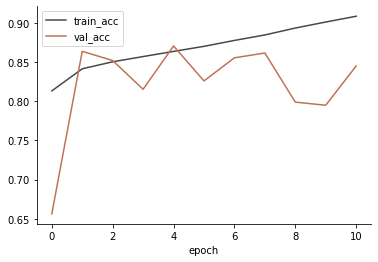

In [14]:
# plot accuracy
plt = acc_plot(history4)
plt.show()

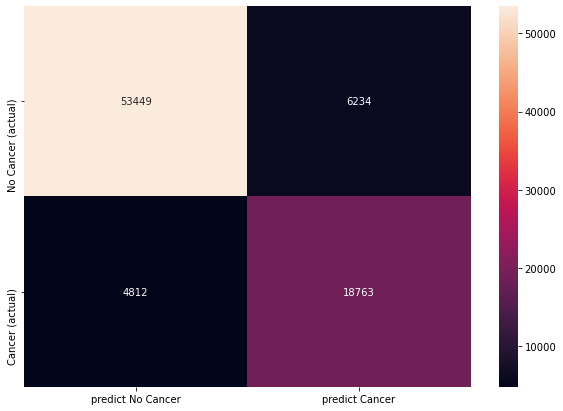

In [15]:
plt = conf_matrix(model, x_test, y_test)
plt.show()

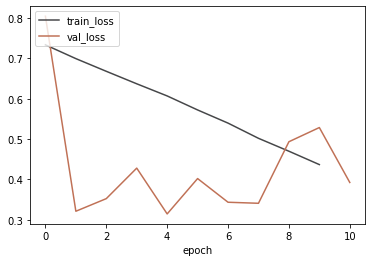

In [16]:
# plot loss
plt = loss_plot(history)
plt.show()